In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from pathlib import Path
import json
import cv2
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
poke2num = dict(json.loads(Path('../data/poke2num.json').read_text()))

In [3]:
icons = Image.open('../data/smicons-sheet.png')
np.array(icons).shape

(3000, 480, 4)

In [4]:
Path('../data/icons').mkdir(exist_ok=True)
icons = Image.open('../data/smicons-sheet.png')
icons_arr = np.array(icons)
for poke, num in poke2num.items():
    top = num // 12 * 30
    left = (num % 12) * 40

    icon = icons_arr[top:top + 30, left:left + 40, :]
    fname = '../data/icons/{}.png'
    # assert not Path(fname).exists()
    Image.fromarray(icon).save(fname.format(poke))

In [5]:
lines = Path('../results/gen7battlespotsingles_ns_256_poke2vec.model').read_text().split('\n')
index2poke = []
n_vocab, n_units = map(int, lines[0].split())
vec = np.zeros((n_vocab, n_units))

for i, line in enumerate(lines[1:]):
    line = line.split()
    if len(line) == 0:
        break
    name, v = line[0], line[1:]
    v = list(map(float, v))
    index2poke.append(name)
    vec[i] = v
    
vocab = {x: i for i, x in enumerate(index2poke)}

In [6]:
pca = PCA(n_components=2)
pca_vec = pca.fit_transform(vec)

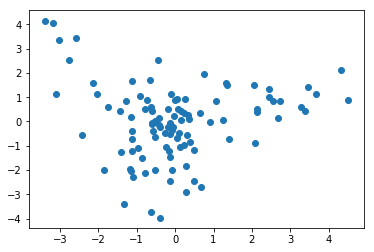

In [7]:
plt.scatter(*pca_vec.T)

In [8]:
def plot(X, index2poke, scale, num_plot=None):
    width = 3000
    height = 3000
    max_dim = 100
    full_image = Image.new('RGB', (width + 200, height + 200))
    xs, ys = X
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    ys = (ys - ys.min()) / (ys.max() - ys.min())

    def calc_pos(x, w):
        return int(x * scale * w)

    for i, name in enumerate(index2poke):
        if name == '<unk>':
            continue
        x, y = xs[i], ys[i]
        tile = Image.open('../data/icons/{}.png'.format(name)).convert("RGBA")
        rs = max(1, tile.width / max_dim, tile.height / max_dim)
        tile = tile.resize((tile.width * 5, tile.height * 5), Image.ANTIALIAS)
        full_image.paste(tile, (calc_pos(y, height), calc_pos(x, width)), tile)

    plt.figure(figsize=(12, 12))
    plt.imshow(full_image)

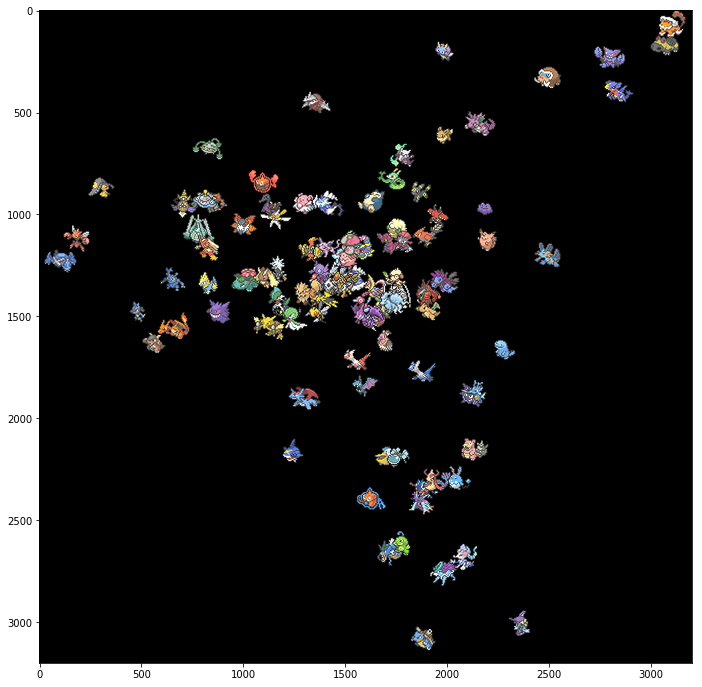

In [9]:
plot(pca_vec.T, index2poke, 1)